# Introduction

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from tabulate import tabulate
pd.options.mode.chained_assignment = None  

## Motivation

Our project was inspired by Tyson Ni's great work in The Daily Bruin in investigating public data, experimenting with technology and applying quantitative insights to real life. Some of his work is available on the Stack, a data journalism and newsroom tech blog which can be found here: https://stack.dailybruin.com/.

In particular, we were very interested in looking at Tyson's analysis of General Education (GE) classes and wanted to see if we could take it a step further and create a model to predict 'easy GEs'. Tyson's original work can be found here: https://stack.dailybruin.com/2016/02/24/grades-ge/

Every UCLA student will understand how inconvenient GE classes are. For many, they represent subjects that the student isn't good at and can be serious GPA-killers. In any case, every student is looking to choose the easiest of GEs, whether they are trying to take the easy way out or simply trying to reduce their overall workload (college is tough, let's admit it). In this case, 'easiest' can be defined as 'most likely to get As'.

Tyson's work includes analysis on several key characteristics:
- Percentage of As for each course
- Frequencies of each course
- Variance in grades for each course

One characteristic that was missing is the professor teaching the course. We felt that professors play a very huge role in determining the ultimate distribution of the grades and should be taken into consideration. We also want to extend Tyson's work by seeing if we can build a model to predict the number of As given certain course features namely:
- Course Name
- Department Name
- GE Foundation
- Professor Name
- Class Size

Notice how the above features are what a regular student would have easy access to when choosing classes on myUCLA (without having to scroll through Bruinwalk and clicking through reviews).

Thus, we contacted Daily Bruin and retrieved two datasets from them:

- **data.csv**: Contains grade information on classes taught in UCLA since 2006 (but effectively since 2013 due to missing data)
- **ge.csv**: Contains GE information on which classes are General Education (GE) classes

We will use these two datasets in our analysis and modeling.

## Data Collection

The Daily Bruin retrieved its grades data via public records requests to the UCLA Registrar. The dataset that we obtained from The Daily Bruin is the same as that which is being used to display grade distribution data on https://www.bruinwalk.com/.

Bruinwalk is a website maintained by the Daily Bruin to give UCLA students an edge in selecting and picking classes that are most optimal for them. Many students, ourselves included, use the data to pick out 'easy' courses that can help as GPA boosters. As such, we will use this same data to see if we can find meaningful patterns in the grades distributions.

Here are just a few limitations of our dataset that we will like to disclose upfront:
- Some courses can count for more than one General Education (GE) category, however our data does not have information on this and maps only one GE category to a relevant GE course
- Some courses are taught by multiple professors, but our data only reflects one professor per course
- We do not have data on course units, and thus, GPA aggregation formulas may not be 100% accurate
- Some courses are renamed and may not be considered the 'same course' in our analysis due to differences in these names

## Features of Grades Dataset data
Each observation in **data** is a class taught at UCLA and each column is a feature of the class. There are a total of 31568 classes and 56 class columns in this dataset.

In [157]:
data = pd.read_csv("data.csv", index_col = 0)
data.shape

(31568, 57)

First we take a look at the columns of the dataset.

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31568 entries, 0 to 31567
Data columns (total 57 columns):
department                     31568 non-null int64
grade_A                        31568 non-null int64
grade_Am                       31568 non-null int64
grade_Ap                       31568 non-null int64
grade_B                        31568 non-null int64
grade_Bm                       31568 non-null int64
grade_Bp                       31568 non-null int64
grade_C                        31568 non-null int64
grade_Cm                       31568 non-null int64
grade_Cp                       31568 non-null int64
grade_D                        31568 non-null int64
grade_Dm                       31568 non-null int64
grade_Dp                       31568 non-null int64
grade_F                        31568 non-null int64
grade_L                        31568 non-null int64
grade_R                        31568 non-null int64
grade_deferred_report          31568 non-null int64
grade_i

### Basic Features

The 2 most basic features that each course has is:
- '**prof_name**': The name of the professor teaching the class (5141 unique)
- '**course_name**': The name of the class as it appears when students enroll in the class on my.ucla (5225 unique)

In [159]:
data.loc[0::1000,['prof_name','course_name']].head()

,prof_name,course_name
0,kuo-nan-liou,A&O SCI 1
1000,rene-a-ong,PHYSICS 89
2000,m-f-marra,JAPAN 110
3000,karen-j-cunningham,ENGL 190H
4000,sarah-h-tolbert,CHEM 20B


In [160]:
print(data.prof_name.nunique(), data.course_name.nunique())

5141 5225


### Time Features

There are 2 features related to time:
- '**term_year**': Year in which the course was taught (range from 2006 - 2017)
- '**term_quarter**': Quarter in which the course was taught - Fall, Winter, Spring and Summer (FA, WI, SP, SU)

We are missing full academic year data for 2006-2012, so we will use only data from 2012 Fall onwards.

In [161]:
data.term_year.astype(str).str.cat(data.term_quarter).unique()

array(['2006SP', '2006FA', '2009FA', '2010WI', '2010SP', '2012FA',
       '2013SU', '2013FA', '2013SP', '2013WI', '2014SU', '2014FA',
       '2014SP', '2014WI', '2015SU', '2015FA', '2015SP', '2015WI',
       '2016SP', '2016SU', '2016WI', '2016FA', '2017FA', '2017SP',
       '2017WI'], dtype=object)

### Department Features

There are 3 categorical variables related to department: 
- '**department**': Department ID number (166 unique)
- '**dept_name**': Department full name (162 unique)
- '**dept_short_name**': Department abbreviated name, that is also found in course names (166 unique)

The 'department' column is just the department ID, which is not very useful in our case because we want to know exactly what the departments are.

In [162]:
data.loc[0::1000,['department','dept_name','dept_short_name']].head()

,department,dept_name,dept_short_name
0,30,Atmospheric and Oceanic Sciences,A&O SCI
1000,147,Physics,PHYSICS
2000,103,Japanese,JAPAN
3000,193,English,ENGL
4000,42,Chemistry and Biochemistry,CHEM


In [163]:
print(data.department.nunique(),data.dept_name.nunique(),data.dept_short_name.nunique())

166 162 166


We notice that there are less department names than there are department IDs, so we want to figure out why there is a discrepancy between the two.

In [164]:
data.loc[data.dept_name.str.contains('[Mm]usic'),['dept_name','dept_short_name']].apply(lambda x: ''.join(x), axis = 1).unique()

array(['EthnomusicologyETHNOMU', 'Music HistoryMUS HST', 'MusicMUSIC',
       'Music IndustryMUS IND', 'EthnomusicologyETHNMUS',
       'Music HistoryMSC HST', 'Music IndustryMSC IND', 'MusicMUSC'],
      dtype=object)

Upon close inspection, we find that the 4 culprits are all the music-related majors which have had their short names changed:
- Ethnomusicology ('ETHNOMU' to 'ETHNMUS')
- Music ('MUSIC' to 'MUSC')
- Music History ('MUS HST' to 'MSC HST')
- Music Industry ('MUS IND' to 'MSC IND')

Because of this, we will use '**dept_name**' to group classes by department.

### Grade Features

There are a total of 46 features related to grades of a class, these form most of the numeric variables in the dataset.

In [165]:
data.columns.str.contains('grade_').sum()

46

In general, there are 2 main types of grade variables:
- '**grade_*x***': Number of students receiving *x* grade for the class
- '**grade_*x*_pct**': Percentage of students receiving *x* grade for the class

In [166]:
data.columns[data.columns.str.contains('grade_')]

Index(['grade_A', 'grade_Am', 'grade_Ap', 'grade_B', 'grade_Bm', 'grade_Bp',
       'grade_C', 'grade_Cm', 'grade_Cp', 'grade_D', 'grade_Dm', 'grade_Dp',
       'grade_F', 'grade_L', 'grade_R', 'grade_deferred_report',
       'grade_in_progress', 'grade_incomplete', 'grade_no_grade_received',
       'grade_no_pass', 'grade_pass', 'grade_satisfactory',
       'grade_unsatisfactory', 'grade_A_pct', 'grade_Am_pct', 'grade_Ap_pct',
       'grade_B_pct', 'grade_Bm_pct', 'grade_Bp_pct', 'grade_C_pct',
       'grade_Cm_pct', 'grade_Cp_pct', 'grade_D_pct', 'grade_Dm_pct',
       'grade_Dp_pct', 'grade_F_pct', 'grade_L_pct', 'grade_R_pct',
       'grade_deferred_report_pct', 'grade_in_progress_pct',
       'grade_incomplete_pct', 'grade_no_grade_received_pct',
       'grade_no_pass_pct', 'grade_pass_pct', 'grade_satisfactory_pct',
       'grade_unsatisfactory_pct'],
      dtype='object')

At the end of a quarter, each student receives a final grade for the course which measures how well the student has performed for the course.

There are 13 different letter grades:
- **Ap, A, Am**: A+/A/A- grades
- **Bp, B, Bm**: B+/B/B- grades
- **Cp, C, Cm**: C+/C/C- grades
- **Dp, D, Dm**: D+/D/D- grades
- **F**: Fail grade


There are also 4 non-letter grades:
- **pass** and **no_pass**: P/NP grading used for some students taking non-major calsses
- **satisfactory** and **unsatisfactory**: S/US grading used for graduate classes (essentially P/NP for graduate classes)


There are 6 other grades:
- **L**: Letter grade but professor has not reported it yet
- **R**: Non-letter grade but professor has not reported it yet
- **in_progress**: IP grade meaning course is still in progress
- **incomplete**: I grade meaning student did not complete the course
- **deferred_report**: DR grade meaning grades have not been reported
- **no_grade_received**: NG grade meaning grades have not been received, similar to deferred report

This gives us a total of 23 possible grade indicators and multiplying by 2 for number and percentage gives us 46 exactly.

In [167]:
grades = ['F','Dm','D','Dp','Cm','C','Cp','Bm','B','Bp','Am','A','Ap']
gradecols = ['grade_' + s for s in grades]
data.loc[:,gradecols].head()

,grade_F,grade_Dm,grade_D,grade_Dp,grade_Cm,grade_C,grade_Cp,grade_Bm,grade_B,grade_Bp,grade_Am,grade_A,grade_Ap
0,2,2,0,1,4,3,7,5,6,15,8,4,2
1,2,0,4,0,2,24,6,11,49,14,6,45,9
2,3,0,8,6,5,19,8,6,39,19,9,72,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,8,10,8,9,14,12,0


In [168]:
gradepctcols = ['grade_' + s + '_pct' for s in grades]
data.loc[:,gradepctcols].head()

,grade_F_pct,grade_Dm_pct,grade_D_pct,grade_Dp_pct,grade_Cm_pct,grade_C_pct,grade_Cp_pct,grade_Bm_pct,grade_B_pct,grade_Bp_pct,grade_Am_pct,grade_A_pct,grade_Ap_pct
0,0.029851,0.029851,0.000000,0.014925,0.059701,0.044776,0.104478,0.074627,0.089552,0.223881,0.119403,0.059701,0.029851
1,0.009569,0.000000,0.019139,0.000000,0.009569,0.114833,0.028708,0.052632,0.234450,0.066986,0.028708,0.215311,0.043062
2,0.014423,0.000000,0.038462,0.028846,0.024038,0.091346,0.038462,0.028846,0.187500,0.091346,0.043269,0.346154,0.004808
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.031746,0.000000,0.126984,0.158730,0.126984,0.142857,0.222222,0.190476,0.000000


### Count Features

There are 3 student count features in the dataset:
- '**num_weighted_grades**': Number of letter grades
- '**num_grades**': Number of letter and non-letter grades
- '**total_students**': Total number of students enrolled

In [169]:
data.loc[:,['num_weighted_grades','num_grades','total_students']].head()

,num_weighted_grades,num_grades,total_students
0,59,67,67
1,172,209,209
2,195,210,208
3,0,14,14
4,63,63,63


## Features of GE dataset ge

**ge** has 308 rows and 7 columns, where each row is a unique General Education (GE) course and the columns are features of the course

In [170]:
ge = pd.read_csv("ge.csv")
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55


In [171]:
ge.shape

(308, 7)

Let's take a look at the columns of **ge**

In [172]:
ge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 7 columns):
Subject       308 non-null object
CatalogNo     308 non-null object
Name          308 non-null object
GE            308 non-null object
MedianA       308 non-null float64
TotClasses    308 non-null int64
ClassSize     308 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 16.9+ KB


The variables are as follows:
- '**Subject**': Matches **dept_short_name** of a course in **data**
- '**CatalogNo**': When combined with **Subject**, matches the **course_name** in of a course in **data**
- '**Name**': Department name, but in a different format from **data**
- '**GE**': General Education Category, with the main and sub categories separated by '-'
- '**MedianA**': Median number of As received from the class
- '**TotClasses**': Total number of such classes taught
- '**ClassSize**': Class capacity

We will ignore 'Name', 'MedianA' and 'TotClasses' columns in our analysis of the data because they may not match with our **data** dataset

In [173]:
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55


# Exploratory Data Analysis

## Adding Term

We want to combine the Term and Year columns because they make more sense together so we create the **term** variable, but we also want it to be sorted in time order Winter -> Spring -> Summer -> Fall

We shouuld also make sure the **term_quarter** variable is also sorted in the same order

In [174]:
data["term"] = data.apply(lambda x: str(x["term_year"]) + "-" + x["term_quarter"], axis=1)
data["term"] = pd.Categorical(data['term'],
                              [str(x) + '-' + y for x in data.term_year.unique() for y in ['WI','SP','SU','FA']],
                             ordered = True)
data['term_quarter'] = pd.Categorical(data['term_quarter'],['WI','SP','SU','FA'], ordered = True)
data.loc[0::2500,['term_year','term_quarter','term']].sort_values('term')

,term_year,term_quarter,term
0,2006,SP,2006-SP
2500,2006,FA,2006-FA
5000,2010,WI,2010-WI
7500,2012,FA,2012-FA
10000,2013,SP,2013-SP
15000,2014,SP,2014-SP
12500,2014,SU,2014-SU
20000,2015,SP,2015-SP
17500,2015,SU,2015-SU
25000,2016,WI,2016-WI


In [175]:
data.loc[::2500,['term_year','term_quarter','term']].sort_values('term_quarter')

,term_year,term_quarter,term
5000,2010,WI,2010-WI
25000,2016,WI,2016-WI
30000,2017,WI,2017-WI
0,2006,SP,2006-SP
10000,2013,SP,2013-SP
15000,2014,SP,2014-SP
20000,2015,SP,2015-SP
22500,2016,SP,2016-SP
12500,2014,SU,2014-SU
17500,2015,SU,2015-SU


## Adding Division

Maybe it would be a good idea to group departments into larger categories like divisions

The different UCLA divisions can be found here: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=division
- Arts And Architecture (AA)
- Basic Biomedical Sciences (BBS)
- Education And Information Studies (EIS)
- Engineering And Applied Sciences (EAS)
- Humanities (HUM)
- International Institute (II)
- Law (LAW)
- Letters And Science -Interdisciplinary (IDP)
- Life Sciences (LS)
- Management (MGMT)
- Medicine (MED)
- Nursing (NUR)
- Physical Sciences (PS)
- Public Affairs (PA)
- Public Health (PH)
- School of Dentistry (DEN)
- School of Music (MUS)
- School of Theater, Film, And Television (TFT)
- Social Sciences (SS)

We added the School of Dentistry because it showed up in our data, making a total of 19 divisions.

We will first create a new column to store this new category by using a dictionary mapping majors to divisions

In [176]:
majordict = {}

**Arts and Architecture Division (7)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=AA

In [177]:
is_aa = ((data.dept_name.str.contains("Art")) & (data.dept_name != "Art History"))  | (data.dept_name == "Dance") | (data.dept_name.str.contains("Architecture"))
for x in data.dept_name.loc[is_aa].unique():
    majordict[x] = 'AA'
data.dept_name.loc[is_aa].unique()

array(['Architecture and Urban Design', 'Art', 'Arts and Architecture',
       'Design | Media Arts', 'World Arts and Cultures', 'Dance',
       'Arts Education'], dtype=object)

**Basic Biomedical Sciences Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=BB

In [178]:
majordict['Microbiology, Immunology, and Molecular Genetics'] = 'BBS'

**Education and Information Studies Division (2)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EI

In [179]:
majordict['Education'] = 'EIS'
majordict['Information Studies'] = 'EIS'

**Engineering and Applied Science Division (9)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=EN

In [180]:
is_eas = (data.dept_name.str.contains("[Ee]ngineer"))| (data.dept_name == "Computer Science")
for x in data.dept_name.loc[is_eas].unique():
    majordict[x] = 'EAS'
data.dept_name.loc[is_eas].unique()

array(['Biomedical Engineering', 'Civil and Environmental Engineering',
       'Chemical Engineering', 'Computer Science',
       'Electrical Engineering', 'Engineering',
       'Materials Science and Engineering',
       'Mechanical and Aerospace Engineering', 'Bioengineering'],
      dtype=object)

Note: Biomedical Engineering has been deprecated since 2011

In [181]:
data.loc[data.dept_name == 'Biomedical Engineering','term_year'].unique()

array([2006, 2009, 2010], dtype=int64)

**Humanities Division (55)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=HU
- Added 'Afrikaans'
- Added 'Czech' due to https://slavic.ucla.edu/languages/czech/

In [182]:
hum = ['American Sign Language', 'Afrikaans',
 'Ancient Near East',
 'Applied Linguistics',
 'Arabic',
 'Armenian',
 'Art History',
 'Asian',
 'Central and East European Studies',
 'Chinese',
 'Classics',
 'Comparative Literature',
 'Digital Humanities',
 'Dutch',
 'English',
 'English as a Second Language',
 'English Composition',
 'Filipino',
 'French',
 'German',
 'Greek',
 'Hebrew',
 'Hindi-Urdu',
 'Hungarian',
 'Indigenous Languages of the Americas',
 'Indo-European Studies',
 'Indonesian',
 'Iranian',
 'Islamic Studies',
 'Italian',
 'Japanese',
 'Jewish Studies',
 'Korean',
 'Latin',
 'Lesbian, Gay, Bisexual, Transgender, and Queer Studies', 'Lesbian, Gay, Bisexual, and Transgender Studies',
 'Linguistics',
 'Middle Eastern Studies',
 'Near Eastern Languages',
 'Philosophy',
 'Polish',
 'Portuguese',
 'Religion, Study of',
 'Romanian',
 'Russian', 'Czech',
 'Scandinavian',
 'Semitics',
 'Serbian/Croatian',
 'Slavic',
 'South Asian',
 'Southeast Asian',
 'Spanish',
 'Swahili',
 'Thai',
 'Turkic Languages',
 'Vietnamese',
 'Yiddish']

In [183]:
for x in hum:
    majordict[x] = 'HUM'
len(hum)

58

**International Institute (7)**

Based on: 
1. https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=IS
2. https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=IS

Modifications:
- Added 'Islamics' for similarity with 'Islamic Studies'
- Added 'African Languages' based on: http://www.international.ucla.edu/asc/article/80598
- Added 'European Studies' based on: http://international.ucla.edu/academics/european
- Removed 'International Migration Studies' and 'African Studies' because they are not found in our data

In [184]:
ii = ['Global Studies','International and Area Studies','International Development Studies',
     'Global Health','Islamic Studies','Latin American Studies', 'African Languages', 'European Studies', 'Islamics',
      'Southeast Asian Studies']
for x in ii:
    majordict[x] = 'II'

**Law Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LW

In [185]:
majordict['Law, Undergraduate'] = 'LAW'

**Interdisciplinary Division (4)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=GS
- Added 'Civic Engagement' due to http://www.uei.ucla.edu/academic-programs/civic-engagement/
- Added 'Human Complex Systems' due to nature of course


In [186]:
idp = ['General Education Clusters','Disability Studies','Environment','Honors Collegium','University Studies',
      'Civic Engagement','Human Complex Systems']
for x in idp:
    majordict[x] = 'IDP'

**Life Sciences Division (9)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=LF
- Moved Neuroscience to Medicine Division
- Added 'Physiology' due to similarity with 'Physiological Science'

In [187]:
ls = ['Biomedical Research','Computational and Systems Biology','Ecology and Evolutionary Biology',
      'Life Sciences','Molecular, Cell, and Developmental Biology', 'Molecular and Medical Pharmacology',
      'Physiological Science','Psychology','Society and Genetics','Physiology']
for x in ls:
    majordict[x] = 'LS'

**Management Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MG

In [188]:
majordict['Management'] = 'MGMT'

**Medicine Division (10)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MN
- Added 'Neurology' due to similarity with 'Neuroscience'
- Added 'Medical History' due to similarity with content
- Added 'Surgery' due to similarity with Medical courses


In [189]:
med = ['Biological Chemistry','Biomathematics','Human Genetics','Medicine','Neurobiology','Neuroscience','Neurology',
       'Psychiatry and Biobehavioral Sciences', 'Medical History','Surgery']
for x in med:
    majordict[x] = "MED"

**School of Nursing Division (1)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=NS

In [190]:
majordict['Nursing'] = 'NUR'

**Physical Science Division (9)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PS
- Dropped 'Planetary' from 'Earth, Planetary and Space Sciences' to match name in **data**

In [191]:
ps = ['Astronomy', 'Atmospheric and Oceanic Sciences', 'Chemistry and Biochemistry', 'Earth and Space Sciences',
      'Mathematics','Physics','Program in Computing','Science Education','Statistics']
for x in ps:
    majordict[x] = "PS"

**Public Affairs Division (3)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PA
- Dropped 'Public Affairs' because it was not found in data

In [192]:
pa = ['Public Policy','Social Welfare','Urban Planning']
for x in pa:
    majordict[x] = "PA"

**Public Health Division (6)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=PH
- Added 'Gerontology' and 'Health Services' due to similarity in course content

In [193]:
ph = ['Biostatistics','Community Health Sciences','Environmental Health Sciences','Epidemiology','Health Policy and Management',
      'Public Health','Gerontology','Health Services']
for x in ph:
    majordict[x] = "PH"

**School of Dentistry Division (1)**

Based on: https://www.dentistry.ucla.edu/about

In [194]:
majordict['Dentistry'] = 'DEN'

**School of Music Division (4)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=MU

In [195]:
mus = data.dept_name.loc[data.dept_name.str.contains("[Mm]us")].unique()
for x in mus:
    majordict[x] = 'MUS'
mus

array(['Ethnomusicology', 'Music History', 'Music', 'Music Industry'],
      dtype=object)

**School of Theater, Film and Television Division (2)**

Based on: https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=TF

In [196]:
majordict['Film and Television'] = 'TFT'
majordict['Theater'] = 'TFT'

**Social Science Division (11)**

Based on: 
1. https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18F&type=subjarea&division=SS
2. https://ccle.ucla.edu/blocks/ucla_browseby/view.php?term=18S&type=subjarea&division=SS

Modifications:
- Removed 'Conservation of Archaeological and Ethnographic Materials' which was not found in data
- Added 'Afro-American Studies' because it is similar to 'African American Studies'
- Added 'Communication' and 'Communication Studies' based on http://comm.ucla.edu/requirements
- Added 'Women's Studies' to replace 'Gender Studies'
- Added 'Military Science' based on http://milsci.ucla.edu/about
- Added 'Naval Science' based on http://www.navy.ucla.edu/
- Added 'Aerospace Studies' based on http://www.afrotc.ucla.edu/
- Added 'Economics' based on https://socialsciences.ucla.edu/departments/

In [197]:
ss = ['African American Studies','Afro-American Studies','American Indian Studies','Anthropology','Asian American Studies',
      'Archaeology','Chicana and Chicano Studies','Geography','History','Political Science','Sociology',
      'Labor and Workplace Studies','Communication', 'Communication Studies',"Women's Studies",'Military Science',
      'Naval Science','Aerospace Studies','Economics']
for x in ss:
    majordict[x] = 'SS'

In [198]:
[x for x in data.dept_name.unique() if x not in majordict.keys()]

[]

In [199]:
data['division'] = [majordict[x] for x in data.dept_name]
data.division.nunique()

19

## Letter Grade Data Analysis

We can plot grade data for each row as a bar plot as follows

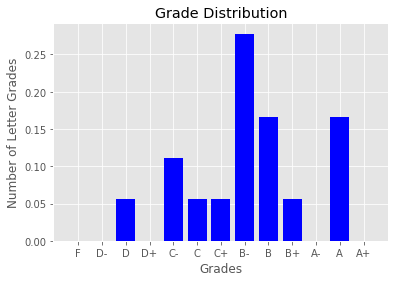

In [200]:
grades2 = ['F','D-','D','D+','C-','C','C+','B-','B','B+','A-','A','A+']
plt.style.use('ggplot')
plt.bar(x = grades2, height = data.loc[20,gradepctcols], color = 'blue')
plt.xlabel('Grades')
plt.ylabel('Number of Letter Grades')
plt.title('Grade Distribution')
plt.show()

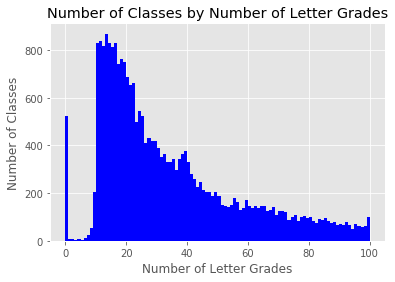

In [201]:
plt.hist(data[gradecols].sum(axis = 1), bins = 100, range = [0,100], color = 'b')
plt.ylabel('Number of Classes')
plt.xlabel('Number of Letter Grades')
plt.title('Number of Classes by Number of Letter Grades')
plt.show()

The histogram above shows the number of classes against number of letter grades received by students. The peak at zero indicates that there are about 500 pass no pass classes that we should deal with.

Although there are also some classes with very low letter grades received (< 10) the number of classes like that is exceptionally small so we can be assured that it will not skew our aggregate data analysis by much.

In [202]:
data.loc[data.loc[:,gradecols].sum(axis = 1) == 0].shape

(524, 59)

We notice that 524 classes are mandatory P/NP classes and should be omitted from our GPA and letter grade analysis
As such, we should split the data into pass-no-pass classes and letter grade classes.

In [203]:
pnpdata = data.loc[data.loc[:,gradecols].sum(axis = 1) == 0]
lgdata = data.loc[~(data.loc[:,gradecols].sum(axis = 1) == 0)]

Some initial questions to consider:
- Is grade inflation a thing?
- Are some professors  more lenient than others?
- Are certain departments more competitive than others?
- Do grades differ across quarters?
    
In order to answer these questions, it might make sense to convert each grade into a GPA to get better numerical results such as the mean, median, quantiles and standard deviations of these distributions.

We will map GPA using the grade point scale found here: https://catalog.registrar.ucla.edu/ucla-catalog18-19-117.html

In [204]:
gradepts = [0,0.7,1.0,1.3,1.7,2.0,2.3,2.7,3.0,3.3,3.7,4.0,4.0]
gradedict = dict(zip(grades2,gradepts))
gradedict

{'F': 0,
 'D-': 0.7,
 'D': 1.0,
 'D+': 1.3,
 'C-': 1.7,
 'C': 2.0,
 'C+': 2.3,
 'B-': 2.7,
 'B': 3.0,
 'B+': 3.3,
 'A-': 3.7,
 'A': 4.0,
 'A+': 4.0}

For each observation, we extract its summary statistics

In [205]:
dist = [[gradepts[i]]*x for i,x in enumerate(data.loc[0,gradecols])]
raw = pd.Series([x for y in dist for x in y])
raw.describe()

count    59.000000
mean      2.816949
std       0.968496
min       0.000000
25%       2.300000
50%       3.000000
75%       3.300000
max       4.000000
dtype: float64

We put the above into 2 functions:
- **tidy(row)**: Takes a row of letter grades and returns the tidy version of it
- **summstats(row)** Applies summary statistics on tidied data

In [206]:
def tidy(row):
    dist = [[gradepts[i]]*x for i,x in enumerate(row)]
    raw = pd.Series([x for y in dist for x in y])
    return(raw)

summstats = lambda row: tidy(row).describe()

In [207]:
## We will only apply it on the head for reference
lgdata.loc[:,gradecols].head().apply(summstats, axis = 1)

,count,mean,std,min,25%,50%,75%,max
0,59.0,2.816949,0.968496,0.0,2.3,3.0,3.3,4.0
1,172.0,3.083140,0.845771,0.0,2.7,3.0,4.0,4.0
2,195.0,3.086667,0.978915,0.0,2.5,3.3,4.0,4.0
4,63.0,3.211111,0.635790,1.7,2.7,3.3,3.7,4.0
5,63.0,3.471429,0.781113,0.0,3.3,3.7,4.0,4.0


Since GPA is actually a discrete numeric variable, the quartiles are not as useful as the mean. From the above, we can see that the quartiles can only take specific discrete points, which are not very informative when we compare across groups. For this reason, we will mostly use mean GPA in the exploration.

### Group by Term

Let’s dive deeper into the data and see what kind of results we can get based on grouping by **term_year** and **term_quarter**

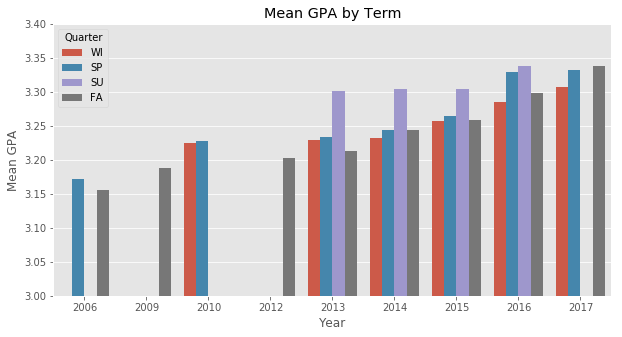

In [208]:
byTerm = lgdata.groupby(['term'])[gradecols].sum().apply(summstats,axis = 1).reset_index().dropna()
byTerm['term_year'] = byTerm['term'].str[:4]
byTerm['term_quarter'] = byTerm['term'].str[5:]
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
sns.barplot(data = byTerm, x = 'term_year', y = 'mean', hue = 'term_quarter', hue_order = ['WI','SP','SU','FA'])
plt.title("Mean GPA by Term")
plt.ylabel("Mean GPA")
plt.xlabel("Year")
plt.legend(title = "Quarter", loc = "upper left")
plt.ylim(3,3.4)
plt.show()

From the above graph, we can clearly see several things:
- There is a clear an upward trend in mean GPA from 2013 to 2017, indicating a strong case for GPA inflation
- Summer quarter tends to have much higher mean GPA, probably because a shorter quarter leads to easier courses
- Spring quarter seems to be the most forgiving out of all the regular quarters, maybe because people graduate in that quarter

For this reason, we will use **term_quarter** as one of our predictor variables.

### Group by Professor

We will look at the differences in grades based on Professor across the whole dataset (not just GEs). Additionally, to account for possible effects of being new professors, we will look at those who have taught more than 500 students.

In [209]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)

In [210]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = False).head(3)

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
i-nyoman-wenten,851.0,3.999295,0.014535,3.7,4.0,4.0,4.0,4.0
donald-neuen,1266.0,3.987046,0.114649,1.7,4.0,4.0,4.0,4.0
john-b-ullmen,541.0,3.986876,0.097343,3.0,4.0,4.0,4.0,4.0


In [211]:
byProf[byProf['count'] > 500].sort_values('mean',ascending = True).head(3)

,count,mean,std,min,25%,50%,75%,max
prof_name,,,,,,,,
gail-e-kennedy,998.0,2.359519,1.229683,0.0,1.7,2.3,3.3,4.0
ngee-low,567.0,2.541623,1.224743,0.0,2.0,2.3,4.0,4.0
demetri-brizolis,969.0,2.558101,1.085431,0.0,2.0,2.7,3.3,4.0


In [212]:
byProf[byProf['count'] > 500]['mean'].max() - byProf[byProf['count'] > 500]['mean'].min()

1.6397759090448867

The range of mean GPAs by professor is rather startling, with the difference between the most lenient and most strict professor having a mean GPA difference of 1.64, which is about a 5 letter grade difference. That's actually the difference between an A and a C+. This means that the average student getting an A in **i-nyoman-wenten's** class would get a C+ in **david-ravetch's** class.

### Group by Department

We will look at the differences in grades based on Department across the whole dataset (not just GEs). Additionally, to account for departments with too few students, we will look at those which have than 500 students.

In [213]:
byDept = lgdata.groupby('dept_name')[gradecols].sum().apply(summstats, axis = 1)
byDept[byDept['count'] > 500].sort_values('mean', ascending = False).head(3)

,count,mean,std,min,25%,50%,75%,max
dept_name,,,,,,,,
Armenian,1354.0,3.901551,0.273958,0.0,4.0,4.0,4.0,4.0
Vietnamese,1277.0,3.847142,0.417770,0.0,4.0,4.0,4.0,4.0
Military Science,1370.0,3.843431,0.386785,0.0,4.0,4.0,4.0,4.0


In [214]:
byDept[byDept['count'] > 500].sort_values('mean', ascending = False).tail(3)

,count,mean,std,min,25%,50%,75%,max
dept_name,,,,,,,,
Neuroscience,17109.0,2.992425,0.838946,0.0,2.3,3.0,3.7,4.0
Chemistry and Biochemistry,126261.0,2.912618,0.928459,0.0,2.3,3.0,3.7,4.0
Mathematics,114675.0,2.862436,0.986767,0.0,2.0,3.0,3.7,4.0


In [215]:
byDept[byDept['count'] > 500]['mean'].max() - byDept[byDept['count'] > 500]['mean'].min()


1.0391145092787313

The range of mean GPAs by department is pretty wide too at 1.04, which is about a 3 letter grade difference. That's actually the difference between an A and a B. This means that the average student getting an A in **Armenian** classes would get a B in **Mathematics** classes.

### Group by Course Name

We will look at the differences in grades based on course name across the whole dataset (not just GEs). Additionally, to account for courses with too few students to make a meaningful mean, we will look at those which have than 500 students.

In [216]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)

In [217]:
byCourse[byCourse['count'] > 500].sort_values('mean', ascending = False).head(3)

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
ETHNOMU 161B,643.0,3.999067,0.016718,3.7,4.0,4.0,4.0,4.0
LIFESCI 192B,609.0,3.997537,0.027093,3.7,4.0,4.0,4.0,4.0
MUSIC 90F,667.0,3.990255,0.161574,0.0,4.0,4.0,4.0,4.0


In [218]:
byCourse[byCourse['count'] > 500].sort_values('mean', ascending = False).tail(3)

,count,mean,std,min,25%,50%,75%,max
course_name,,,,,,,,
NEUROSC 102,2380.0,2.659076,1.025549,0.0,2.0,3.0,3.3,4.0
MGMT 1B,3406.0,2.480593,1.107050,0.0,2.0,2.7,3.3,4.0
ANTHRO 129Q,848.0,2.332901,1.250960,0.0,1.7,2.3,3.3,4.0


In [219]:
byCourse[byCourse['count'] > 500]['mean'].max() - byCourse[byCourse['count'] > 500]['mean'].min()

1.6661659306317693

The range of mean GPAs by course name is actually the widest at 1.67, which is about a 5 letter grade difference. That's actually the difference between an A and a C+. This means that the average student getting an A in a **ETHNOMU 161B** course would get a C+ in an **ANTHRO 129Q** course.

**ETHNOMU 161B** is Advanced World Music Performance Organizations: Music of Bali which is only taught by one professor - yes, you guessed it - **i-nyoma-wenten** the same one who appeared at the top of the list in the group by professors section above. Here's the Bruinwalk Link: https://www.bruinwalk.com/professors/i-nyoman-wenten/ethnomu-161b/. The distribution from Bruinwalk matches with our expectations.

**ANTHRO 129Q** is Paleopathology with the Bruinwalk link: https://www.bruinwalk.com/professors/gail-e-kennedy/anthro-129q/. Scrolling through the distributions also matches with our expectaitons, because there are high failure rates and low A rates.

### Group by Division

Just for interest, we want to see if there is a difference in divisions. With a bigger category than departments, we can actually plot the mean GPA by division on a graph.

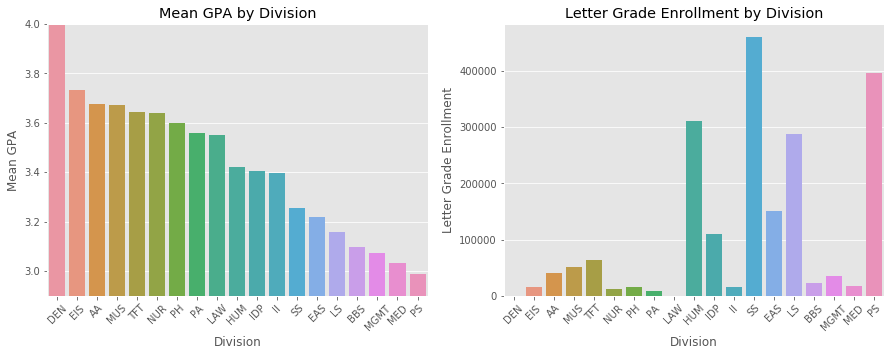

In [220]:
byDivision = lgdata.groupby('division')[gradecols].sum().apply(summstats, axis = 1)
gpa_by_division = byDivision.sort_values('mean', ascending = False).reset_index()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(data = gpa_by_division, x = 'division', y = 'mean')
plt.ylim(2.9,4)
plt.title("Mean GPA by Division")
plt.ylabel("Mean GPA")
plt.xlabel("Division")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data = gpa_by_division, x = 'division', y = 'count')
plt.title("Letter Grade Enrollment by Division")
plt.ylabel("Letter Grade Enrollment")
plt.xlabel("Division")
plt.xticks(rotation=45)
plt.show()

Dentistry should be taken as an outlier since there are only 15 of such course instances taken and GPA is 4.0

The divisions at the top of the GPA spread are:
- Education and Information Systems
- School of Arts and Architecture
- School of Music
- School of Theater, Film and Television

Meanwhile, the majors at the bottom of the spread with medians of 3.0 are:
- Physical Sciences
- Medicine

We also see from here that the most popular classes are from:
- Social Sciences
- Physical Sciences
- Humanities
- Life Sciences

This is to be expected because these form the bulk of the classes in the College of Letters and Science

Meanwhile, the least popular classes are from:
- School of Law
- School of Dentistry
- School of Public Affairs
- School of Nursing

## General Education Analysis

### Percentage A grade Variable

The most important concern for students is whether a GE will "hurt" one's GPA, thus percentage of A/A+ will be a good gauge of whether a course is actually "easy" or otherwise. We will call this variable '**gpa_4_pct**' because it is the percentage of students who scored 4.0 gpa for that course.

In [221]:
lgdata['gpa_4_pct'] = lgdata['grade_A_pct'] + lgdata['grade_Ap_pct']
lgdata.loc[:,['grade_A_pct','grade_Ap_pct','gpa_4_pct']].head()

,grade_A_pct,grade_Ap_pct,gpa_4_pct
0,0.059701,0.029851,0.089552
1,0.215311,0.043062,0.258373
2,0.346154,0.004808,0.350962
4,0.190476,0.000000,0.190476
5,0.190476,0.269841,0.460317


### Short note on Selection Bias

We understand that the option to choose P/NP or Letter Grade for GEs produces a selection bias where more confident students with higher aptitude will opt for letter grades in the classes they know they are strong in whilst less confident or students with lower aptitude will opt for P/NP grades. This generally causes letter grades to be inflated higher than they would have been otherwise, so that the mean GPA may not be a very good indicator of Course Difficulty.

For example, a class could be so difficult that everyone chooses to P/NP it except for 1 person, who is a genius and ends up getting an A+. The average mean GPA of that class is 4.0 but in reality, if everyone who chose to P/NP took it, it would have been much lower.

However, with limited data on student characteristics, it is difficult to calculate how much more difficult a class is than it appears. We could perhaps apply a P/NP penalty to a class, in a couple of ways:
- Assigning P to C- (borderline pass) and NP to D+ (borderline fail) respectively to decrease the mean GPA
- Using total number of grades rather than letter grade enrollment to calculate mean GPA

Therefore, the data modelling section, we will use **gpa_4_pct** which uses the total number of grades to account for this selection bias. We feel that this could be a slightly better indicator of course difficulty.

### Merging GE information

We need to merge GE information from **ge** into **data**

In [222]:
ge["course_name"] = ge.apply(lambda x: x["Subject"] + " " + x["CatalogNo"],axis=1)
ge.loc[0::100,['Subject','CatalogNo','course_name']]

,Subject,CatalogNo,course_name
0,A&O SCI,1,A&O SCI 1
100,EPS SCI,13,EPS SCI 13
200,ITALIAN,46,ITALIAN 46
300,STATS,12,STATS 12


In [223]:
ge['foundation'] = ge["GE"].apply(lambda x: x.split("-")[0])
ge['category'] = ge["GE"].apply(lambda x: x.split("-")[1])
ge.loc[:,['GE','foundation','category']].head()

,GE,foundation,category
0,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
2,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences
3,Society and Culture-Historical Analysis,Society and Culture,Historical Analysis
4,Society and Culture-Historical Analysis,Society and Culture,Historical Analysis


We create a new column **requirement** which is just the abbreviated form of the **GE** column, that we can use to plot nicely on a chart.

In [224]:
ge.GE.unique()
gedict = dict(zip(ge.GE.unique(),['SI-PS','SC-HA','SI-LS','SC-SA','AH-PLA','AH-VPA','AH-LCA']))
ge['requirement'] = [gedict[x] for x in ge.GE]
ge.head()

,Subject,CatalogNo,Name,GE,MedianA,TotClasses,ClassSize,course_name,foundation,category,requirement
0,A&O SCI,1,CLIMATE CHANGE,Scientific Inquiry-Physical Sciences,0.34,10,150,A&O SCI 1,Scientific Inquiry,Physical Sciences,SI-PS
1,A&O SCI,2,AIR POLLUTION,Scientific Inquiry-Physical Sciences,0.32,11,169,A&O SCI 2,Scientific Inquiry,Physical Sciences,SI-PS
2,A&O SCI,3,INTR-ATMOS ENVIRMNT,Scientific Inquiry-Physical Sciences,0.30,6,65,A&O SCI 3,Scientific Inquiry,Physical Sciences,SI-PS
3,AF AMER,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.57,2,42,AF AMER 6,Society and Culture,Historical Analysis,SC-HA
4,AFRO-AM,6,BLACK INTLCTL THGHT,Society and Culture-Historical Analysis,0.47,3,55,AFRO-AM 6,Society and Culture,Historical Analysis,SC-HA


In [225]:
data_ge = lgdata.merge(ge, on = 'course_name')
data_ge.loc[0::500,['course_name','GE','foundation','category','requirement']].head()

,course_name,GE,foundation,category,requirement
0,A&O SCI 1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS
500,FILM TV 106A,Arts and Humanities-Visual and Performance Art...,Arts and Humanities,Visual and Performance Arts Analysis and Practice,AH-VPA
1000,PHYSICS 10,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS
1500,STATS 10,Scientific Inquiry-Life Sciences,Scientific Inquiry,Life Sciences,SI-LS
2000,GEOG 1,Scientific Inquiry-Physical Sciences,Scientific Inquiry,Physical Sciences,SI-PS


In [226]:
gpa_by_GE = data_ge.groupby('requirement')[gradecols].sum().apply(summstats, axis = 1).sort_values('mean', ascending = False).reset_index()
gpa_by_GE.head()

,requirement,count,mean,std,min,25%,50%,75%,max
0,AH-VPA,63525.0,3.447591,0.636029,0.0,3.0,3.7,4.0,4.0
1,AH-LCA,27136.0,3.399539,0.738566,0.0,3.0,3.7,4.0,4.0
2,SC-HA,50345.0,3.372941,0.746779,0.0,3.0,3.7,4.0,4.0
3,SC-SA,54539.0,3.311348,0.773178,0.0,3.0,3.7,4.0,4.0
4,AH-PLA,40115.0,3.296011,0.742976,0.0,3.0,3.3,3.7,4.0


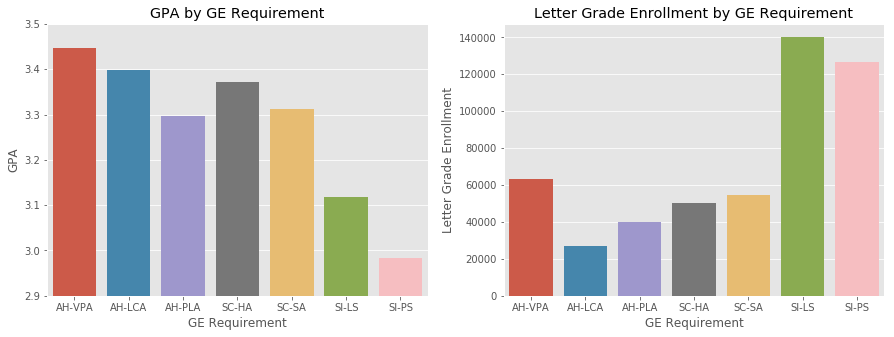

In [227]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(data = gpa_by_GE, x = 'requirement', y = 'mean',
            order = ['AH-VPA','AH-LCA','AH-PLA','SC-HA','SC-SA','SI-LS','SI-PS'])
plt.ylim(2.9,3.5)
plt.title("GPA by GE Requirement")
plt.ylabel("GPA")
plt.xlabel("GE Requirement")

plt.subplot(1,2,2)
sns.barplot(data = gpa_by_GE, x = 'requirement', y = 'count',
            order = ['AH-VPA','AH-LCA','AH-PLA','SC-HA','SC-SA','SI-LS','SI-PS'])
plt.title("Letter Grade Enrollment by GE Requirement")
plt.ylabel("Letter Grade Enrollment")
plt.xlabel("GE Requirement")

plt.show()

From the above plots, we can see several things:
- Foundations of Scientific Inquiry has the lowest GPAs out of all the foundations
- Physical Sciences is the toughest GE category with the lowest mean GPA below 3.0
- Visual Performing Arts Analysis and Practice is the easiest GE category with the highest mean GPA above 3.4
- Mean of Physical Science GEs is more than a full grade lower than the mean of Visual Performing Arts GEs
- For the most part, mean GPA seems negatively correlated with letter grade enrollment, though this may just be caused by Science GEs having bigger classes than the others

Since the type of GE requirement plays a large role in Mean GPA, we will subset our data to just the Scientific Inquiry GEs for the data modeling section to reduce the side of our categorical data.

### Adding Variables

We want to create a 3 new variables:
- **prof_mean**: Mean GPA of the professor, used to indicate Professor Leniency
- **prof_freq**: Number of times the professor has taught classes, also used to indicate how experienced the professor is, and perhaps whether or not the professor is visiting or tenured 
- **course_mean**: Mean GPA of the course, used to indicate Course Difficulty

In [228]:
byProf = lgdata.groupby('prof_name')[gradecols].sum().apply(summstats, axis = 1)
profs = byProf.loc[:,'count':'std'].reset_index()
profs.columns = ["prof_name","prof_count","prof_mean","prof_std"]
profs.head()

,prof_name,prof_count,prof_mean,prof_std
0,a-a-gooch,39.0,3.341026,0.997818
1,a-a-schnurr,70.0,3.230000,0.872170
2,a-b-kaplan,48.0,3.979167,0.144338
3,a-b-mathur,59.0,2.798305,1.017179
4,a-b-saposnik,212.0,3.629717,0.486026


In [229]:
byCourse = lgdata.groupby('course_name')[gradecols].sum().apply(summstats, axis = 1)
courses = byCourse.loc[:,'count':'std'].reset_index()
courses.columns = ["course_name","course_count","course_mean","course_std"]
courses.head()

,course_name,course_count,course_mean,course_std
0,A&O SCI 1,2670.0,3.228427,0.780949
1,A&O SCI 101,217.0,3.097235,0.817172
2,A&O SCI 102,608.0,3.293586,0.697920
3,A&O SCI 103,528.0,2.956818,0.824731
4,A&O SCI 104,685.0,2.941168,0.887502


In [230]:
profcount = lgdata.groupby('prof_name')['dept_name'].count().reset_index()
profcount.columns = ['prof_name', 'prof_freq']
profcount.head()

,prof_name,prof_freq
0,a-a-gooch,1
1,a-a-schnurr,4
2,a-b-kaplan,1
3,a-b-mathur,1
4,a-b-saposnik,5


In [231]:
data_ge_profcourse = data_ge.merge(profs, on = "prof_name").merge(courses, on = "course_name").merge(profcount, on = "prof_name")
data_ge_profcourse.head()

,department,grade_A,grade_Am,grade_Ap,grade_B,grade_Bm,grade_Bp,grade_C,grade_Cm,grade_Cp,...,foundation,category,requirement,prof_count,prof_mean,prof_std,course_count,course_mean,course_std,prof_freq
0,30,4,8,2,6,5,15,3,4,7,...,Scientific Inquiry,Physical Sciences,SI-PS,88.0,3.021591,0.970774,2670.0,3.228427,0.780949,3
1,30,25,39,4,19,16,40,4,3,7,...,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949,4
2,30,22,36,2,17,15,36,7,3,9,...,Scientific Inquiry,Physical Sciences,SI-PS,430.0,3.369302,0.670968,2670.0,3.228427,0.780949,4
3,30,21,23,1,24,13,28,11,4,10,...,Scientific Inquiry,Physical Sciences,SI-PS,744.0,3.253629,0.760260,2670.0,3.228427,0.780949,9
4,30,12,19,2,13,7,14,0,0,2,...,Scientific Inquiry,Physical Sciences,SI-PS,536.0,3.484515,0.592163,2670.0,3.228427,0.780949,8


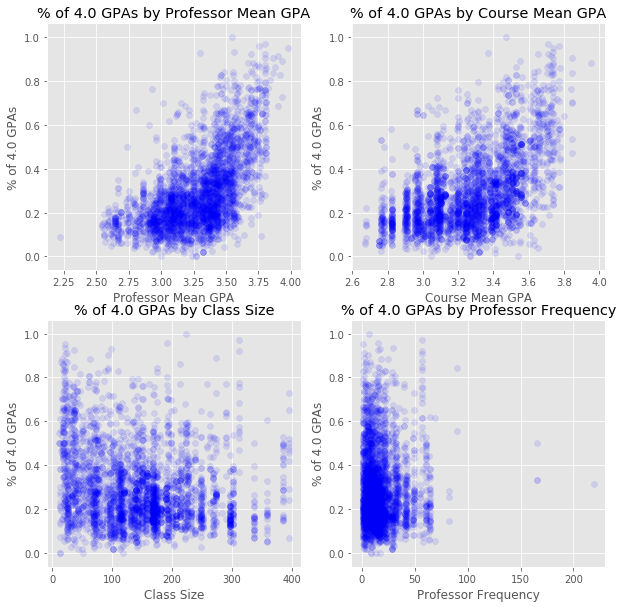

In [232]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(data_ge_profcourse['prof_mean'],data_ge_profcourse['gpa_4_pct'], alpha = .1, color = 'blue')
plt.title("% of 4.0 GPAs by Professor Mean GPA")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Professor Mean GPA")

plt.subplot(2,2,2)
plt.scatter(data_ge_profcourse['course_mean'],data_ge_profcourse['gpa_4_pct'], alpha = .1, color = 'blue')
plt.title("% of 4.0 GPAs by Course Mean GPA")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Course Mean GPA")

plt.subplot(2,2,3)
plt.scatter(data_ge_profcourse['ClassSize'],data_ge_profcourse['gpa_4_pct'], alpha = .1, color = 'blue')
plt.title("% of 4.0 GPAs by Class Size")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Class Size")

plt.subplot(2,2,4)
plt.scatter(data_ge_profcourse['prof_freq'],data_ge_profcourse['gpa_4_pct'], alpha = .1, color = 'blue')
plt.title("% of 4.0 GPAs by Professor Frequency")
plt.ylabel("% of 4.0 GPAs")
plt.xlabel("Professor Frequency")

plt.show()

In [233]:
for x in ['prof_mean','course_mean', 'ClassSize', 'prof_freq']:
    print("Correlation of gpa_4_pct with " + str(x) + ": " +
          str(np.corrcoef(data_ge_profcourse['gpa_4_pct'], data_ge_profcourse[x])[0,1]))

Correlation of gpa_4_pct with prof_mean: 0.5832295935290691
Correlation of gpa_4_pct with course_mean: 0.5186555223412526
Correlation of gpa_4_pct with ClassSize: -0.19791320952020502
Correlation of gpa_4_pct with prof_freq: -0.01161315541037915


While both graphs show a positive correlation, we notice that the correlation is stronger for the professor mean GPA than the course mean GPA. Hence, this suggests that the effect of professor leniency could be stronger than the effect of course difficulty when it comes to grades.

Although mean GPA seems mostly uncorrelated with Class Size and Professor Frequency, the negative correlation coefficient suggests that if there is any effect, it would probably be that smaller class sizes and newer professors lead to slightly better grades.

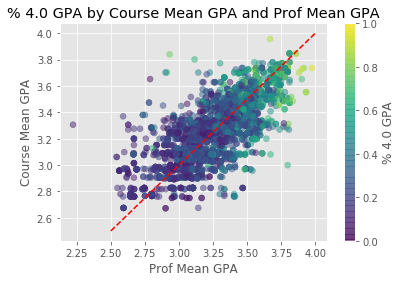

In [234]:
#### plt.figure(figsize=(7,5))
plt.scatter(data_ge_profcourse['prof_mean'],data_ge_profcourse['course_mean'], c = data_ge_profcourse['gpa_4_pct'], cmap = 'viridis', alpha = .5)
plt.title('% 4.0 GPA by Course Mean GPA and Prof Mean GPA')
plt.ylabel('Course Mean GPA')
plt.xlabel('Prof Mean GPA')
plt.xlim()
plt.plot([2.5,4], [2.5, 4], color='r', linestyle='--')
cbar = plt.colorbar()
cbar.ax.set_ylabel('% 4.0 GPA', rotation = 90)
plt.show()

In [235]:
help(plt.colorbar)

Help on function colorbar in module matplotlib.pyplot:

colorbar(mappable=None, cax=None, ax=None, **kw)
    Add a colorbar to a plot.
    
    Function signatures for the :mod:`~matplotlib.pyplot` interface; all
    but the first are also method signatures for the
    :meth:`~matplotlib.figure.Figure.colorbar` method::
    
      colorbar(**kwargs)
      colorbar(mappable, **kwargs)
      colorbar(mappable, cax=cax, **kwargs)
      colorbar(mappable, ax=ax, **kwargs)
    
    Parameters
    ----------
    mappable :
        The :class:`~matplotlib.image.Image`,
        :class:`~matplotlib.contour.ContourSet`, etc. to
        which the colorbar applies; this argument is mandatory for the Figure
        :meth:`~matplotlib.figure.Figure.colorbar` method but optional for the
        pyplot :func:`~matplotlib.pyplot.colorbar` function, which sets the
        default to the current image.
    
    cax : :class:`~matplotlib.axes.Axes` object, optional
        Axes into which the colorbar wil

We can see that if we use both Course Mean GPA and Prof Mean GPA, we could get better results for predicting the % of As for a particular course

From the above plots, we can see that Mean GPAs varies by 3-4 whole grades across departments, which is a very big difference. The effect is the most pronounced for Scientific Inquiry Foundation GEs. For this reason, we will perform our machine learning algorithm on the **Scientific Inquiry** Foundation.

# Data Modeling: Classification

### Rationale

We chose to perform classification rather than regression to keep in line with our underlying goal to determine which GEs are "easy" or otherwise. Next, we want to perform a supervised classification because we already have the data to determine which GE courses are considered "easy", based on criteria that can be observed in the data.

We considered several supervised classification models such as:
- Logistic Regression
- Decision Trees
- Random Forest (builds upon Decision Trees)

*Logistic Regression vs Decision Trees*

**Logistic Regression** is generally quicker than **Decision Trees**. However, we chose to use a Decisioin Tree type of model rather than **Logistic Regression** because of a few key reasons.
- **High Dimensionality**: Our data includes many unique departments, and so one hot encoding that categorical variable will produce too many features. **Logistic Regression** is generally used when features are linearly independent, however, in our case, we understand that our features themselves may be correlated, such as the Department affected the Professor or Course. Hence, **Decision Trees** are better as non-linear classifiers.
- **Imbalanced classes**: We do not expect that number of easy GEs to be comparable to the number of non-easy GEs. In fact, most GEs should be difficult, and so **Decision Trees** tend to outperform **Logistic Regression** in this case

*Decision Trees vs Random Forest*

However, **Decision Trees** are weak on their own and are prone to overfitting data. Ideally, we would like to minimize both error due to bias and error due to variance. **Random Forests** use a collection of **Decision Trees** and take an aggregated average of the results to produce the model. This has several advantages:
- *Limits overfitting* without increasing error due to bias
- *Variance reduction* by training on different samples of data as well as using random subsets of features

Therefore, we decided to employ the **Random Forest Classifier** as our model of choice.

### Outcome Variable

We will define a new outcome variable:
- **is_easy**: 1 if **gpa_4_pct** is greater than the third quartile of all GEs and 0 otherwise, meaning an "easy GE" has percentage of As that's higher than 75% of all GEs. 

This will ensure we do not have overwhelming class imbalance that could make classification difficult.

In [236]:
q3 = data_ge_profcourse['gpa_4_pct'].quantile(0.75)
q3

0.37142857142857144

### Feature Selection

We will mainly be looking at GEs that belong to Scientific Inquiry since this has the most number of GE classes.

Based on our data exploration above, we decided to use these features:

**Categorial Variables**
- **dept_name**: Department name
- **term_quarter**: Quarter in which the course was taught
- **category**: Subcategories of GEs within each foundation

Our data exploration above showed that department and GE categories do impact the mean GPA received in the course, which is a significant difference. Also, we also saw how having summer has a term quarter increases the mean GPA by a little, so we included term quarter as well, even the effect might not be as pronounced.

**Numeric Variables**
- **course_mean**: Mean GPA of a course, indicates Course Difficulty
- **prof_mean**: Mean GPA of a professor, indicates Professor Leniency
- **ClassSize**: Class capacity of the course
- **prof_freq**: Number of times a professor has taught courses at UCLA, indicates how experienced the professor is and whether or not perhaps the professor is visiting or tenured

Our data exploration above showed that **course_mean** and **prof_mean** are highly correlated with **gpa_4_pct**, and so we definitely have to include them in our features. Also, although **prof_freq** and **ClassSize** seemed somewhat uncorrelated with **gpa_4_pct**, we decided to include them anyway just to see if the model can confirm for us that these features are perhaps not as significant as the other two.

### Subsetting Data to Science GEs

In [237]:
data_ge_profcourse["is_easy"] = (data_ge_profcourse['gpa_4_pct'] > q3).astype(int)
ge_subset = data_ge_profcourse[["prof_name","dept_name","course_mean","prof_mean",
                                "term_quarter","total_students","term","term_year","course_name",
                                "is_easy","prof_freq","ClassSize","foundation","category","requirement"]]
ge_subset[ge_subset["is_easy"]==1].shape[0]/ge_subset.shape[0]
ge_subset.head()

,prof_name,dept_name,course_mean,prof_mean,term_quarter,total_students,term,term_year,course_name,is_easy,prof_freq,ClassSize,foundation,category,requirement
0,kuo-nan-liou,Atmospheric and Oceanic Sciences,3.228427,3.021591,SP,67,2006-SP,2006,A&O SCI 1,0,3,150,Scientific Inquiry,Physical Sciences,SI-PS
1,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,FA,171,2006-FA,2006,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
2,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,WI,177,2016-WI,2016,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
3,j-david-neelin,Atmospheric and Oceanic Sciences,3.228427,3.253629,FA,154,2009-FA,2009,A&O SCI 1,0,9,150,Scientific Inquiry,Physical Sciences,SI-PS
4,carlos-mechoso,Atmospheric and Oceanic Sciences,3.228427,3.484515,WI,79,2010-WI,2010,A&O SCI 1,0,8,150,Scientific Inquiry,Physical Sciences,SI-PS


In [238]:
# focus on just one category (Scientific Inquiry) of GE since it has the most number of classes
science_ge = ge_subset[ge_subset["foundation"]=="Scientific Inquiry"]
print("# of Departments: " + str(science_ge.dept_name.nunique()))
print("Proportion of Easy Science GEs: " + str(science_ge.is_easy.mean()))

# of Departments: 23
Proportion of Easy Science GEs: 0.1724137931034483


In [239]:
science_ge.reset_index(inplace=True)
del science_ge['index']
science_ge.head()

,prof_name,dept_name,course_mean,prof_mean,term_quarter,total_students,term,term_year,course_name,is_easy,prof_freq,ClassSize,foundation,category,requirement
0,kuo-nan-liou,Atmospheric and Oceanic Sciences,3.228427,3.021591,SP,67,2006-SP,2006,A&O SCI 1,0,3,150,Scientific Inquiry,Physical Sciences,SI-PS
1,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,FA,171,2006-FA,2006,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
2,alexander-hall,Atmospheric and Oceanic Sciences,3.228427,3.369302,WI,177,2016-WI,2016,A&O SCI 1,0,4,150,Scientific Inquiry,Physical Sciences,SI-PS
3,j-david-neelin,Atmospheric and Oceanic Sciences,3.228427,3.253629,FA,154,2009-FA,2009,A&O SCI 1,0,9,150,Scientific Inquiry,Physical Sciences,SI-PS
4,carlos-mechoso,Atmospheric and Oceanic Sciences,3.228427,3.484515,WI,79,2010-WI,2010,A&O SCI 1,0,8,150,Scientific Inquiry,Physical Sciences,SI-PS


### Data Preprocessing

We will one hot encode the categorial variables and scale the continuous variables

In [240]:
# get the categorical variables and one_hot encode

cat_variables = science_ge[["dept_name","term_quarter","category"]]
le = preprocessing.LabelEncoder()
X_2 = cat_variables.apply(le.fit_transform)
enc = preprocessing.OneHotEncoder()
enc.fit(X_2)
cat_variables_onehot = enc.transform(X_2).toarray()
        
# get the numeric variables and feature scale them 
numeric_variables = science_ge[["prof_freq","ClassSize","course_mean","prof_mean"]]
scaler = preprocessing.StandardScaler()
numeric_variables_scaled = scaler.fit_transform(numeric_variables)

# concatenate one hot encoding of categorical variables with the numeric variables
X = np.c_[numeric_variables_scaled, cat_variables_onehot]

# get the is_easy_class label
y = science_ge.is_easy.values

print(X.shape)

(1450, 33)


### Splitting of training and testing data

We chose the most recent 20% of our data as the hold-out set, which we will use for testing our model

In [241]:
# splitting into training and testing data

x_test_index = science_ge[(science_ge["term_year"] == 2017) |
                          (science_ge["term"]=="2016-SU") |
                          (science_ge["term"]=="2016-SP")].index.values
x_train_index = np.setdiff1d(science_ge.index.values, x_test_index)
print("# of Test Cases: " + str(len(x_test_index)))
print("# of Training Cases: " + str(len(x_train_index)))

# of Test Cases: 303
# of Training Cases: 1147


In [242]:
X_test = X[x_test_index]
X_train = X[x_train_index]
print(X_test.shape)
print(X_train.shape)

(303, 33)
(1147, 33)


In [243]:
y_train = y[x_train_index]
y_test = y[x_test_index]
print(y_test.shape)
print(y_train.shape)

(303,)
(1147,)


In [244]:
y_test.shape[0]/y.shape[0]

0.20896551724137932

Hence, we see that about 20% of our data is used as test data.

### Grid Search with Cross Validation

We will first initialize some parameters, then use Randomized Search with 5-fold Cross Validation to narrow down the better parameters, before finally using Grid Search with 5-fold Cross Validation to confirm the best parameters. 

Random Forest has 6 hyperparameters:
- **n_estimators**: The number of trees in the random forest
- **max_features**: The number of features to consider at each split
- **max_depth**: Maximum number of levels in a tree
- **min_samples_split**: Minimum number of samples required to split a node
- **min_samples_leaf**: Minimum number of samples required at a leaf node
- **bootstrap**: Method of selecting samples for training each tree (either True or False)

In [245]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [246]:
# randomized search

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=False, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [247]:
# grid search

# Create the parameter grid based on the results of randomized search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20,30],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}

# Create a tree-based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = False)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best = grid_search.best_params_
best

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 300}

### Random Forest Classifier 


We discovered that a decision threshold of 0.5 results in a lot of false negatives, whereby the model is not able to detect "easy" classes. This is because the classes are imbalanced, with very few classes being labeled as "easy". 

Hence, we will need to find the best decision threshold that optimizes the F1 score, which will ensure that both precision and recall are high. 

At the same time, we will also create a Random Forest Classifier model that takes in the best params that we found earlier through the grid search. 

In [248]:
# this aims to optimize F1 score, and returns best_f1, best_threshold after lopping through 

def find_best_threshold(model):
    best_threshold = 0.01
    best_f1 = 0
    threshold = 0.01
    while threshold < 0.5:
        y_train_prediction_prob = model.predict_proba(X_train)
        y_train_prediction = (y_train_prediction_prob [:,1] >= threshold).astype('int')
        f1 = f1_score(y_train,y_train_prediction)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        threshold += 0.01
    return(best_f1,best_threshold)

In [249]:
# creates the random forest model with the params we found earlier 
# find the best decision threshold

rnd_clf = RandomForestClassifier(bootstrap=best["bootstrap"],max_depth=best["max_depth"],max_features=best["max_features"],min_samples_leaf=best["min_samples_leaf"],min_samples_split=best["min_samples_split"],n_estimators=best["n_estimators"], n_jobs=-1, random_state=42)
model = rnd_clf.fit(X_train, y_train)
best_threshold = find_best_threshold(model)
best_threshold

(0.7158469945355191, 0.23000000000000007)

### Model Evaluation

We used the following methods to evaluate our model:
- **Confusion Matrix**: True positives (TP) on top left, false positive (FP) on top right, false negative (FN) on bottom left, true negative (TN) on bottom right. $$Confusion Matrix = \begin{bmatrix}TP & FP \\ FN & TN \end{bmatrix}$$
- **Precision** is a measure of a classifiers exactness. A low precision indicates many False Positives. $$Precision = \frac{TP}{FP}$$
- **Recall** is a measure of a classifiers completeness. A low recall indicates many False Negatives. $$Recall = \frac{TP}{TP+FN}$$
- **F1 score** conveys the balance between the precision and the recall.The higher the F1 score, the better the model.
$$F1 = 2\times\frac{Precision \times Recall}{Precision + Recall}$$
- **ROC curve** plots the probability of predicting true positive, against false positive. The greater the area below ROC, the better the model.

In [250]:
# creates a function to plot roc curve
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Postitive Rate")

In [251]:
# uses predict_proba() to give a probability of classifying a class as "easy" or not
# then makes the decision to classify a class as "easy" using the best decision threshold found earlier
y_train_prediction_prob = model.predict_proba(X_train)
y_train_prediction = (y_train_prediction_prob [:,1] >= best_threshold[1]).astype('int')
print(confusion_matrix(y_train,y_train_prediction))
print("f1 score:" + str(f1_score(y_train,y_train_prediction)))

[[912  64]
 [ 40 131]]
f1 score:0.7158469945355191


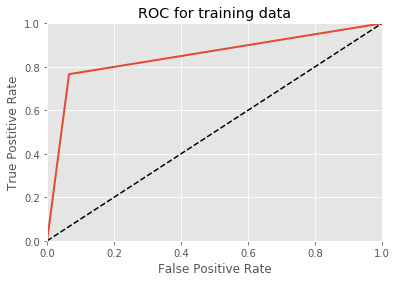

In [252]:
# plots ROC curve for training data 
fpr, tpr, thresholds = roc_curve(y_train,y_train_prediction)
plot_roc_curve(fpr,tpr)
plt.title("ROC for training data")
plt.show()

In [253]:
# predicting on hold out test data

y_test_prediction_prob = model.predict_proba(X_test)
y_test_prediction = (y_test_prediction_prob [:,1] >= best_threshold[1]).astype('int')
print(confusion_matrix(y_test,y_test_prediction))
print("f1 score: " + str(f1_score(y_test,y_test_prediction)))

[[203  21]
 [ 38  41]]
f1 score: 0.5815602836879432


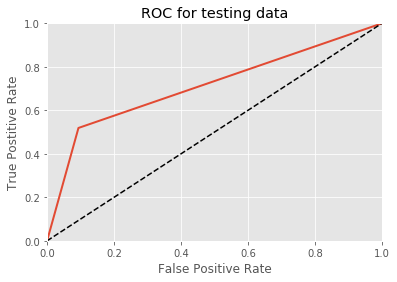

In [254]:
# ROC for testing data
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test,y_test_prediction)
plot_roc_curve(fpr_2,tpr_2)
plt.title("ROC for testing data")
plt.show()

We see that the difference in F1 score and area below ROC curves between the training and testing set are not so great, hence explaining that there is not much overfitting.

Overfitting has been largely overcome by the cross validation we employed earlier on. 

Grid search allows us to find the best parameters to classify accurately and reduce the number of false positives. 

Finding the best decision threshold allows us to classify more precisely and reduce the number of false negatives. 



### Feature Significance 

Random forest model takes in these features and compute an importance score based on how much each feature decreases the impurity of a tree, meaning how impactful that feature can help to increase the accuracy of prediction.

In [255]:
# get the labels of categorical variables from one-hot-encoding

labels = {}
for i in range(len(cat_variables.columns)):
    for j in range(len(cat_variables[cat_variables.columns[i]].unique())):
        my_key = cat_variables.columns[i] + "*" + cat_variables[cat_variables.columns[i]].unique()[j]
        labels[my_key] = X_2[X_2.columns[i]].unique()[j]
        
# also put in the labels of continuous variables
labels_ordered = ["prof_frequency","ClassSize","course_mean","prof_mean"]

# put the labels into data frame and then have a new column for the first part of label, do a group_by, then sort
# then get the labels into an ordered list 
temporary = pd.Series(labels).to_frame().reset_index().rename(columns={'index': 'label', 0: 'label_order'})
temporary["original"]=temporary["label"].apply(lambda x: x.split("*")[0])
temporary = temporary.groupby("original",sort = False).apply(lambda x: x.sort_values(["label_order"])).reset_index(drop=True)

# then append to labels_ordered 
for i in temporary.label.values:
    labels_ordered.append(i)

In [256]:
# print out the values 
values = sorted(zip(labels_ordered, model.feature_importances_), key=lambda x: x[1] * -1)
headers = ["feature", "significance_score"]
print(tabulate(values, headers, tablefmt="plain"))

feature                                                 significance_score
prof_mean                                                      0.296891
course_mean                                                    0.228662
ClassSize                                                      0.151112
prof_frequency                                                 0.0448829
dept_name*Nursing                                              0.0389051
term_quarter*SU                                                0.0306388
category*Physical Sciences                                     0.0267914
category*Life Sciences                                         0.023208
dept_name*Life Sciences                                        0.020128
term_quarter*FA                                                0.0179536
dept_name*Physiological Science                                0.0159215
dept_name*Physics                                              0.0143455
dept_name*Earth and Space Sciences                    

We discovered that the mean GPA given by professor, the mean GPA of a particular course, the class size, how often the professor gives lectures, the Life Sciences department, and the summer quarter are important indicators of feature importance.

This correlates with our earlier exploratory analysis whereby we discovered that whether or not a class is "easy" is very much dependent on the professor, the nature of the course, the department and the quarter. 

## Future Research

### Other Graduation Requirements

We were limited by our computing power, but with more time, models of each GE Foundation Category can be fitted as well so that we can have a prediction of the best courses to take under each category. In total, we would have 6 models for all 6 categories. However, we would also require a dataset that gives us full details on *all* the categories that a particular course fulfills, which could be possibly scraped from the registrar website or course information pages.

If the data was available, we could also look into classes which satisfy:
- Diversity requirement
- Writing II requirement

We could then also fit and test models for the Diversity and Writing II requirements and see which courses are the best to take under those special requirements. 

### Student Characteristics

Since our dataset did not contain any student data, we were unable to perform analysis on factors related to Student Aptitude, which we feel can have a strong impact on the grades attained in a course.

Student Aptitude could be estimated if we had data regarding
- **Student major**: An indicator of student expertise or passion for a particular area of study
- **Student GPA**: An indicator of how well a student performs in graded assignments
- **Student quarter course units**: An indicator of how busy a student is in a quarter

All of the above features would be very interesting to study and would, in our opinion, probably be the best indicator of whether a student can achieve an A/A+ grade in a class.

Furthermore, demographic information could also be invaluable to UCLA
- Student race/ethnicity
- Student gender
- Student age
- Student transfer status
- Student athlete status

These factors could help UCLA better cater academic support programs to certain groups of students who may be performing worse than their peers. 
- UCLA claims to uphold diversity and inclusion, but are students from every minority group achieving similar levels of academic success? 
- Is there more that UCLA can and should do to help particular groups of students who are struggling with their courses?

These type of questions could be further addressed with data on students.

### Model Selection

Although we only tried one model in this study, testing out other models could be useful in figuring out which of our predictor variables are the most important and significant. For example, in our model, we found that most of the department and quarter information were not as significant as compared to predictor variables like Professor Leniency, Course Difficulty and Class Size, hence we could run another model omitting the less significant variables and seeing if our model performs better or worse and by how much.

Also, we could  try using **regression** instead of **classification**. Our outcome variable **gpa_4_pct** is a numeric variable after all and a regression model could be used with a loss function that penalizes complexity. In our case, we wanted to keep things simple because most students classify GEs as either "easy" or "not easy" in their heads. However, not all students define "easy" in the same way (while some think >25% A/A+ rate is course, others might only think >50% A/A+ rate is an easy course). In all cases however, students are simply trying to maximize the probability that they receive A/A+ grades, so a regression could help give better detail regarding the "continuous spectrum" of GE easiness, which may be closer to the reality.

### Causal Relations

Drawing from Judea Pearl's book *The Book of Why*, we can also propose a causal model which leads to the grade received:

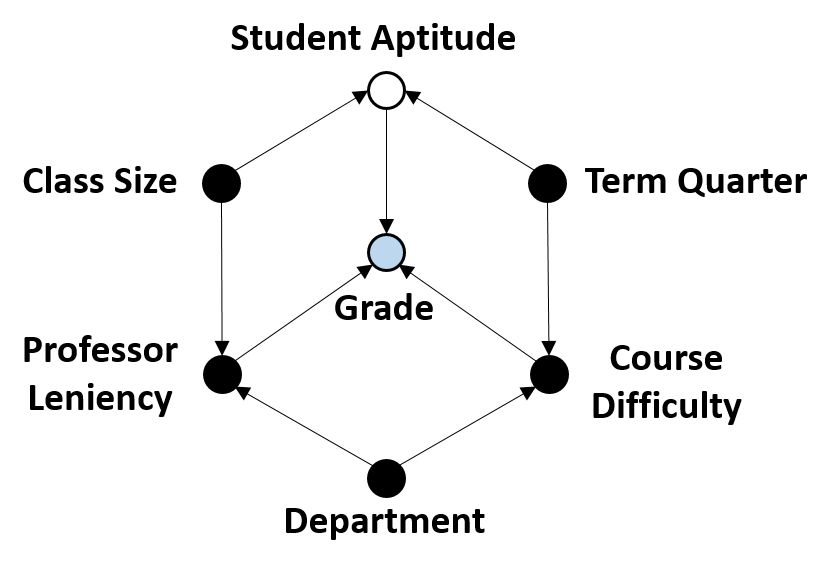

The diagram helps us to distinguish between direct causes (or mediators) and indirect causes and can help to estimate the effect of each cause (denoted by arrows) independent of or dependent on other effects.

From this causal diagram, we could try to estimate for example:
- How much control the Department has over Professor Leniency
- How much Class Size affects Student Aptitude
- How much Term Quarter affects Class Difficulty

However, such a causal calculus is beyond the scope of this class, though it would be an interesting endeavour.